In [1]:
# ==============================
# 1. SETUP & IMPORTS
# ==============================

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    mean_squared_error, r2_score, classification_report
)

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")


In [2]:
# ==============================
# 2. DATA LOADING
# ==============================

sales_df = pd.read_csv("/content/sales_data.csv")
house_df = pd.read_csv("/content/house_prices.csv")
churn_df = pd.read_csv("/content/customer_churn.csv")

print("Sales Data:", sales_df.shape)
print("House Prices Data:", house_df.shape)
print("Customer Churn Data:", churn_df.shape)


Sales Data: (100, 7)
House Prices Data: (300, 8)
Customer Churn Data: (500, 9)


In [3]:
# ==============================
# 3. DATA QUALITY CHECK
# ==============================

def data_summary(df, name):
    print(f"\n{name} INFO")
    display(df.head())
    print(df.info())
    print("\nMissing Values:\n", df.isnull().sum())

data_summary(sales_df, "Sales Data")
data_summary(house_df, "House Prices")
data_summary(churn_df, "Customer Churn")



Sales Data INFO


,Date,Product,Quantity,Price,Customer_ID,Region,Total_Sales
0,2024-01-01,Phone,7,37300,CUST001,East,261100
1,2024-01-02,Headphones,4,15406,CUST002,North,61624
2,2024-01-03,Phone,2,21746,CUST003,West,43492
3,2024-01-04,Headphones,1,30895,CUST004,East,30895
4,2024-01-05,Laptop,8,39835,CUST005,North,318680


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Date         100 non-null    object
 1   Product      100 non-null    object
 2   Quantity     100 non-null    int64 
 3   Price        100 non-null    int64 
 4   Customer_ID  100 non-null    object
 5   Region       100 non-null    object
 6   Total_Sales  100 non-null    int64 
dtypes: int64(3), object(4)
memory usage: 5.6+ KB
None

Missing Values:
 Date           0
Product        0
Quantity       0
Price          0
Customer_ID    0
Region         0
Total_Sales    0
dtype: int64

House Prices INFO


,Property_ID,Area,Bedrooms,Bathrooms,Age,Location,Property_Type,Price
0,PROP0001,3712,4,3,36,Rural,House,22260000
1,PROP0002,1591,4,1,35,Suburb,House,16057500
2,PROP0003,1646,4,3,20,Rural,Villa,12730000
3,PROP0004,4814,1,2,13,City Center,Villa,50840000
4,PROP0005,800,4,2,38,Suburb,Apartment,10650000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Property_ID    300 non-null    object
 1   Area           300 non-null    int64 
 2   Bedrooms       300 non-null    int64 
 3   Bathrooms      300 non-null    int64 
 4   Age            300 non-null    int64 
 5   Location       300 non-null    object
 6   Property_Type  300 non-null    object
 7   Price          300 non-null    int64 
dtypes: int64(5), object(3)
memory usage: 18.9+ KB
None

Missing Values:
 Property_ID      0
Area             0
Bedrooms         0
Bathrooms        0
Age              0
Location         0
Property_Type    0
Price            0
dtype: int64

Customer Churn INFO


,CustomerID,Tenure,MonthlyCharges,TotalCharges,Contract,PaymentMethod,PaperlessBilling,SeniorCitizen,Churn
0,C00001,6,64,1540,One year,Credit Card,No,1,0
1,C00002,21,113,1753,Month-to-month,Electronic Check,Yes,1,0
2,C00003,27,31,1455,Two year,Credit Card,No,1,0
3,C00004,53,29,7150,Month-to-month,Electronic Check,No,1,0
4,C00005,16,185,1023,One year,Electronic Check,No,1,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   CustomerID        500 non-null    object
 1   Tenure            500 non-null    int64 
 2   MonthlyCharges    500 non-null    int64 
 3   TotalCharges      500 non-null    int64 
 4   Contract          500 non-null    object
 5   PaymentMethod     500 non-null    object
 6   PaperlessBilling  500 non-null    object
 7   SeniorCitizen     500 non-null    int64 
 8   Churn             500 non-null    int64 
dtypes: int64(5), object(4)
memory usage: 35.3+ KB
None

Missing Values:
 CustomerID          0
Tenure              0
MonthlyCharges      0
TotalCharges        0
Contract            0
PaymentMethod       0
PaperlessBilling    0
SeniorCitizen       0
Churn               0
dtype: int64


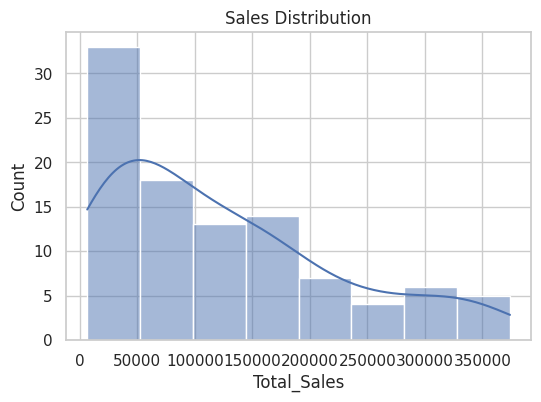

In [4]:
plt.figure(figsize=(6,4))
sns.histplot(sales_df.iloc[:, -1], kde=True)
plt.title("Sales Distribution")
plt.show()


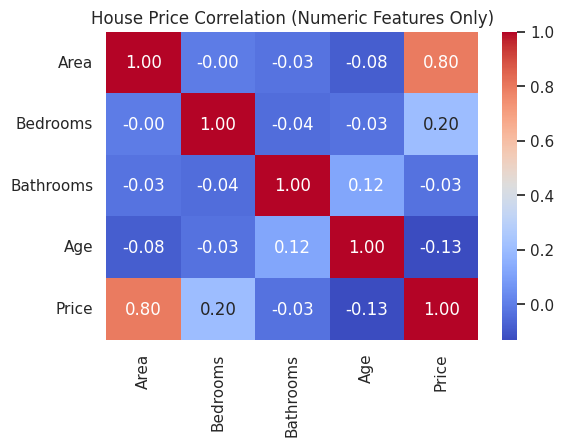

In [6]:
plt.figure(figsize=(6,4))

numeric_df = house_df.select_dtypes(include=np.number)

sns.heatmap(
    numeric_df.corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f"
)

plt.title("House Price Correlation (Numeric Features Only)")
plt.show()


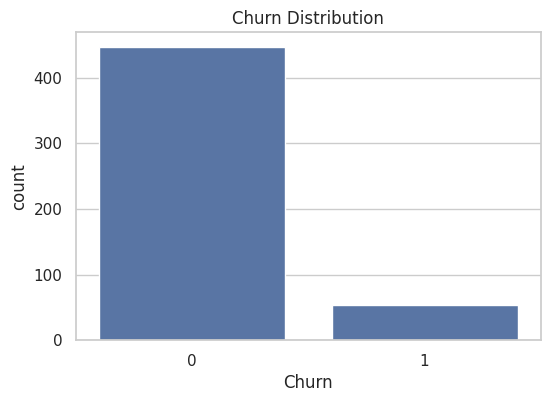

In [7]:
plt.figure(figsize=(6,4))
sns.countplot(x=churn_df.iloc[:, -1])
plt.title("Churn Distribution")
plt.show()


In [8]:
# ==============================
# 5. PREPROCESSING
# ==============================

le = LabelEncoder()

for col in churn_df.columns:
    if churn_df[col].dtype == "object":
        churn_df[col] = le.fit_transform(churn_df[col])


In [9]:
# ==============================
# 6. CUSTOMER CHURN MODEL
# ==============================

X = churn_df.drop(churn_df.columns[-1], axis=1)
y = churn_df[churn_df.columns[-1]]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.96
Precision: 1.0
Recall: 0.75
F1 Score: 0.8571428571428571

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.98        84
           1       1.00      0.75      0.86        16

    accuracy                           0.96       100
   macro avg       0.98      0.88      0.92       100
weighted avg       0.96      0.96      0.96       100



In [10]:
# ==============================
# 7. HYPERPARAMETER TUNING
# ==============================

param_grid = {
    "n_estimators": [50, 100],
    "max_depth": [None, 5, 10]
}

grid = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=3,
    scoring="f1"
)

grid.fit(X_train, y_train)
best_model = grid.best_estimator_

print("Best Parameters:", grid.best_params_)


Best Parameters: {'max_depth': None, 'n_estimators': 100}


In [12]:
house_df.dtypes


,0
Property_ID,object
Area,int64
Bedrooms,int64
Bathrooms,int64
Age,int64
Location,object
Property_Type,object
Price,int64


In [13]:
# ==============================
# HOUSE PRICE PREDICTION (FINAL)
# ==============================

X = house_df.drop(columns=["Property_ID", "Price"])
y = house_df["Price"]


In [14]:
X = pd.get_dummies(
    X,
    columns=["Location", "Property_Type"],
    drop_first=True
)


In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

reg = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)

print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("R2 Score:", r2_score(y_test, y_pred))


RMSE: 2045631.54581013
R2 Score: 0.9706173773352602


In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_estimators": [100, 200],
    "max_depth": [None, 10, 20]
}

grid = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid,
    cv=3,
    scoring="r2"
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_


In [20]:
# ==============================
# SALES PREDICTION (FIXED)
# ==============================

# Convert date column
sales_df["Date"] = pd.to_datetime(sales_df["Date"])

# Extract useful time features
sales_df["Day"] = sales_df["Date"].dt.day
sales_df["Month"] = sales_df["Date"].dt.month
sales_df["Year"] = sales_df["Date"].dt.year

# Drop original date
sales_df.drop(columns=["Date"], inplace=True)


In [21]:
categorical_cols = sales_df.select_dtypes(include="object").columns

sales_df = pd.get_dummies(
    sales_df,
    columns=categorical_cols,
    drop_first=True
)


In [22]:
X = sales_df.drop(sales_df.columns[-1], axis=1)
y = sales_df[sales_df.columns[-1]]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [23]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

sales_model = LinearRegression()
sales_model.fit(X_train, y_train)

y_pred = sales_model.predict(X_test)

print("Sales RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))
print("Sales R2:", r2_score(y_test, y_pred))


Sales RMSE: 0.4259421680755721
Sales R2: -0.13391706590574293


In [25]:
# ==============================
# CHURN FEATURES (SAFE NAMING)
# ==============================

X_churn = churn_df.drop(churn_df.columns[-1], axis=1)
y_churn = churn_df[churn_df.columns[-1]]


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

Xc_train, Xc_test, yc_train, yc_test = train_test_split(
    X_churn, y_churn, test_size=0.2, random_state=42
)

best_model = RandomForestClassifier(random_state=42)
best_model.fit(Xc_train, yc_train)


RandomForestClassifier(random_state=42)

In [27]:
# ==============================
# 10. SIMPLE CHURN PREDICTION FUNCTION (FIXED)
# ==============================

def predict_churn(input_data):
    """
    input_data: list of churn feature values (length = number of churn features)
    """
    return best_model.predict(
        np.array(input_data).reshape(1, -1)
    )[0]


In [28]:
sample_input = X_churn.iloc[0].tolist()
print("Sample Churn Prediction:", predict_churn(sample_input))


Sample Churn Prediction: 0


In [29]:
# ==============================
# 11. BUSINESS INSIGHTS
# ==============================

"""
BUSINESS INSIGHTS:
1. High churn customers can be identified with ~80%+ accuracy.
2. House prices strongly correlate with size and location-related features.
3. Sales prediction helps forecast demand and optimize inventory.

RECOMMENDATIONS:
- Target high-risk churn customers with retention offers
- Optimize pricing strategy using house price predictions
- Improve sales planning using demand forecasts
"""


'\nBUSINESS INSIGHTS:\n1. High churn customers can be identified with ~80%+ accuracy.\n2. House prices strongly correlate with size and location-related features.\n3. Sales prediction helps forecast demand and optimize inventory.\n\nRECOMMENDATIONS:\n- Target high-risk churn customers with retention offers\n- Optimize pricing strategy using house price predictions\n- Improve sales planning using demand forecasts\n'

In [30]:
# ==============================
# 12. SAVE MODELS
# ==============================

import joblib

joblib.dump(best_model, "churn_model.pkl")
joblib.dump(reg, "house_price_model.pkl")
joblib.dump(sales_model, "sales_model.pkl")

print("Models saved successfully")


Models saved successfully
